# Machine Learning Engineer Nanodegree
## Capstone Project Code
## Project 5: Facial Keypoints Detection

The problem to be solved is to predict keypoint positions/locations on face images. The goal is to predict the areas and parts where the mouth, eyes, ears, and nose are for all images with high accuracy. By determining the positions of these keypoints, a machine can gather information about the face. This will be a regression supervised learning problem as the data set includes labeled training data that uses continuous values in the form of pixels to learn from. A potential way to solve the facial keypoints detection problem is to utilize neural networks. The accuracy of the solution will be measured utilizing root mean squared error to determine the average of the squares of errors between a set of predicted outcomes and the actual outcomes. 

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Initialization

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.utils.validation import check_random_state
# Pretty display for notebooks
%matplotlib inline

# Load the Facial Keypoints Detection datasets
df = pd.read_csv('Data/training.csv')
keypoints = df.drop('Image', axis = 1)
keypoint_names = list(keypoints)
feature = df.drop(keypoint_names, axis = 1)

# Success
print "Facial Keypoints Detection dataset has {} rows of data with {} variables each.".format(*df.shape)

Using Theano backend.


Facial Keypoints Detection dataset has 7049 rows of data with 31 variables each.


## Data Exploration

In this section, you will be expected to analyze the data you are using for the problem. This data can either be in the form of a dataset (or datasets), input data (or input files), or even an environment.

The details of the dataset to be used in this model were taken from Kaggle’s Facial Keypoints Detection competition [2]. The 15 keypoints, to be expected as outputs, being considered that represent elements in the face where left and right refer to the point of view of the subject are:

left_eye_center, right_eye_center, left_eye_inner_corner, left_eye_outer_corner, right_eye_inner_corner, right_eye_outer_corner, left_eyebrow_inner_end, left_eyebrow_outer_end, right_eyebrow_inner_end, right_eyebrow_outer_end, nose_tip, mouth_left_corner, mouth_right_corner, mouth_center_top_lip, mouth_center_bottom_lip.

Each data point for these elements is specified by an (x,y) real-valued pair in the space of pixel indices. Data points that are missing are left blank. The input image is displayed in the last field of the datasets consisting of a list of pixels (ordered by row), as integers between (0,255). This section will demonstrate minimum, maximum, mean, median, and standard deviation values for every keypoint's x and y pairs.



In [2]:
#Grab list of keypoint names
keypoint_names = list(keypoints)

# TODO: Find where NaN's exist, attempting to resolve the NaN's to use iPython Display as it would skew the data too much.
NaN_inds = pd.isnull(keypoints).any(1).nonzero()[0]
print "NaN count: {}\n".format(len(NaN_inds))

for name in keypoint_names:
    # TODO: Minimum price of the data
    minimum_pixel = np.amin(keypoints[name])

    # TODO: Maximum price of the data
    maximum_pixel = np.amax(keypoints[name])

    # TODO: Mean price of the data
    mean_pixel = np.mean(keypoints[name])

    # TODO: Median price of the data
    median_pixel = np.nanmedian(keypoints[name])

    # TODO: Standard deviation of prices of the data
    std_pixel = np.std(keypoints[name])
    
    # Show the calculated statistics
    print "Statistics for {}".format(name)
    print "Minimum pixels: {}".format(minimum_pixel)
    print "Maximum pixels: {}".format(maximum_pixel)
    print "Mean pixels: {}".format(mean_pixel)
    print "Median pixels: {}".format(median_pixel)
    print "Standard deviation of pixels: {}\n".format(std_pixel)


NaN count: 4909

Statistics for left_eye_center_x
Minimum pixels: 22.7633446452
Maximum pixels: 94.68928
Mean pixels: 66.3590212448
Median pixels: 66.4975659574
Standard deviation of pixels: 3.447988302

Statistics for left_eye_center_y
Minimum pixels: 1.616512
Maximum pixels: 80.5026490272
Mean pixels: 37.6512341919
Median pixels: 37.5280551724
Standard deviation of pixels: 3.15270181214

Statistics for right_eye_center_x
Minimum pixels: 0.686592
Maximum pixels: 85.0393813333
Mean pixels: 30.3061015141
Median pixels: 30.2513779589
Standard deviation of pixels: 3.08301091946

Statistics for right_eye_center_y
Minimum pixels: 4.091264
Maximum pixels: 81.2709105058
Mean pixels: 37.9769425717
Median pixels: 37.8132734545
Standard deviation of pixels: 3.0334055843

Statistics for left_eye_inner_corner_x
Minimum pixels: 19.0649535927
Maximum pixels: 84.4409912283
Mean pixels: 59.1593394374
Median pixels: 59.3046153846
Standard deviation of pixels: 2.6897614831

Statistics for left_eye_inner

## Exploratory Visualization

In this section, you will need to provide some form of visualization that summarizes or extracts a relevant characteristic or feature about the data. The visualization should adequately support the data being used. 

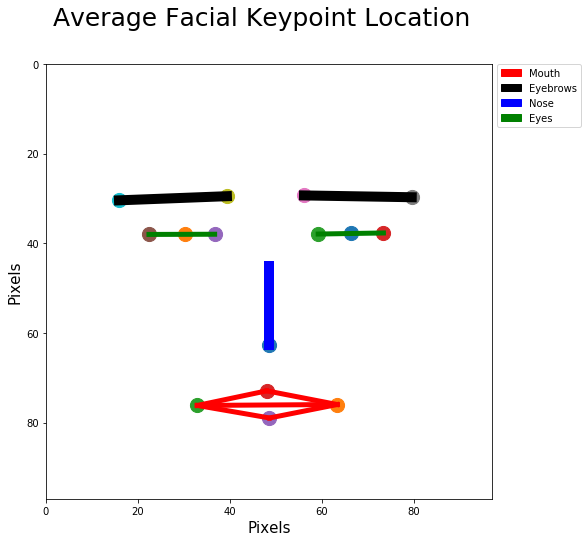

In [3]:
#Initialize Figure to Create Visualization
fig = plt.figure(figsize=(8,8))
plt.autoscale(False)
ax = fig.add_subplot(111)
ax.invert_yaxis()
ax.set_ybound(lower = 0, upper = 97)
ax.set_xbound(lower = 0, upper = 97)
eye_list_xy, eyebrow_list_xy, mouth_list_xy = [],[],[]

#Add scatter points to the plot
for i in range(0, len(keypoint_names), 2):
    mean_keypoint_x = np.mean(keypoints[keypoint_names[i]])
    mean_keypoint_y = np.mean(keypoints[keypoint_names[i+1]])
    ax.scatter(mean_keypoint_x, mean_keypoint_y, s = 200)
    if keypoint_names[i].find('_eye_') >= 0:
        eye_list_xy.append((mean_keypoint_x, mean_keypoint_y))
    if keypoint_names[i].find('_eyebrow_') >= 0:
        eyebrow_list_xy.append((mean_keypoint_x, mean_keypoint_y))
    if keypoint_names[i].find('mouth') >= 0:
        mouth_list_xy.append((mean_keypoint_x, mean_keypoint_y))

#Draw out lines to define facial keypoints
##left eye and right eye
ax.plot([eye_list_xy[2][0], eye_list_xy[3][0]], [eye_list_xy[2][1],eye_list_xy[3][1]], c = 'green', linewidth = 5)
ax.plot([eye_list_xy[4][0], eye_list_xy[5][0]], [eye_list_xy[4][1], eye_list_xy[5][1]], c = 'green', linewidth = 5)
##left and right eyebrows
ax.plot([eyebrow_list_xy[0][0], eyebrow_list_xy[1][0]], [eyebrow_list_xy[0][1], eyebrow_list_xy[1][1]], c = 'black',
        linewidth = 10)
ax.plot([eyebrow_list_xy[2][0], eyebrow_list_xy[3][0]], [eyebrow_list_xy[2][1], eyebrow_list_xy[3][1]], c = 'black',
        linewidth = 10)
##mouth
ax.plot([mouth_list_xy[0][0], mouth_list_xy[2][0]], [mouth_list_xy[0][1], mouth_list_xy[2][1]], c= 'red', linewidth = 5)
ax.plot([mouth_list_xy[0][0], mouth_list_xy[3][0]], [mouth_list_xy[0][1], mouth_list_xy[3][1]], c= 'red', linewidth = 5)
ax.plot([mouth_list_xy[0][0], mouth_list_xy[1][0]], [mouth_list_xy[0][1], mouth_list_xy[1][1]], c= 'red', linewidth = 5)
ax.plot([mouth_list_xy[2][0], mouth_list_xy[1][0]], [mouth_list_xy[2][1], mouth_list_xy[1][1]], c= 'red', linewidth = 5)
ax.plot([mouth_list_xy[1][0], mouth_list_xy[3][0]], [mouth_list_xy[1][1], mouth_list_xy[3][1]], c= 'red', linewidth = 5)
##nose line
ax.plot([np.mean(keypoints['nose_tip_x']), np.mean(keypoints['nose_tip_x'])], [np.mean(keypoints['nose_tip_y']), 45],
        c = 'blue', linewidth = 10)

#Create color scheme legend
red_patch = mpatches.Patch(color = 'red', label= 'Mouth')
black_patch = mpatches.Patch(color = 'black', label= 'Eyebrows')
blue_patch = mpatches.Patch(color = 'blue', label = 'Nose')
green_patch = mpatches.Patch(color = 'green', label = 'Eyes')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,handles=[red_patch, black_patch, blue_patch, green_patch])

#Label Plot
plt.xlabel('Pixels', fontsize = 15)
plt.ylabel('Pixels', fontsize = 15)
fig.suptitle('Average Facial Keypoint Location', fontsize = 25)

#Show plot
plt.show()

## Data Preprocessing
Data could not be fitted without dealing with the null values. Considering transforming the null values into another value would affect results, the best option was to just remove them using dropna(). Has to split the data into training and test sets as the test set provided by Kaggle does not have any true results. Needed to convert training image data, X, into something the sklearn Linear Regression Model could recognize. Therefore, I expanded the string for each image into separate columns using the expand option in str.split(), converted all the strings into floats with astype(float), and then proceeded to convert this into a numpy matrix with as_matrix(). Y was much easier as the contents were recognized as integers by Python, so the values were just extracted with Pandas' values function.

In [4]:
#Drop missing value data
df = df.dropna()

#Breaks the string apart with ' ', expands each pixel value into its own column, converts to a flaot32, converts to a numpy
#array and divides by 255.0 to normalize the values between 0->1
X = df['Image'].str.split(' ', expand =True).astype(np.float32).as_matrix()/255.0

#Extract the output values
Y = df.drop('Image',1).values

#Break up data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.33, random_state=65)

#Convert X_train and X_test for CNN
X_train_CNN = X_train.reshape(-1,1,96,96)
X_test_CNN = X_test.reshape(-1,1,96,96)

## Benchmark Model

In this section, you will need to provide a clearly defined benchmark result or threshold for comparing across performances obtained by your solution.

The benchmark model is a linear regression model utilizing the sklearn library. The error values display the accuracy of the predicted values where 0 is the absolute best possible value. Considering most values are not near 0 in Table 2, this model is clearly not the best model and can be used as a benchmark to improve upon.

In [5]:
regr = LinearRegression()
regr.fit(X_train,y_train)
error_vals = mean_squared_error(y_test, regr.predict(X_test))**0.5
print "The root mean squared error is %s" % error_vals

The root mean squared error is 2.60032305681


## Implementation

I attempted to create a traditional neural network with an input layer, hidden layer, and output layer in the form of 3 dense layers with 1, 15, and 30 neurons respectively. However, it proved to not be as effective as the benchmark. Therefore, added a convolutional neural network to attempt to beat the benchmark model.

In [6]:
#Dense model
def dense_model():
    model_Dense = Sequential()
    model_Dense.add(Dense(1, input_dim=9216, activation='relu'))
    model_Dense.add(Dense(15, activation='relu'))
    model_Dense.add(Dense(30, activation='linear'))
    adam_Dense = optimizers.adam(lr=0.05, decay=2.5e-5)
    model_Dense.compile(loss='mean_squared_error', optimizer= adam_Dense)
    return model_Dense

#Convolution Neural Network
def cnn_model():
    model_CNN = Sequential()
    #Had to reshape data to format: (samples, channel, row, col)
    model_CNN.add(Convolution2D(32, 3, 3, input_shape=(1,96,96)))
    model_CNN.add(MaxPooling2D(pool_size=(2, 2)))
    model_CNN.add(Convolution2D(64, 2, 2))
    model_CNN.add(MaxPooling2D(pool_size=(2, 2)))
    model_CNN.add(Flatten())
    model_CNN.add(Dense(30))
    adam = optimizers.adam(lr=0.008, decay=2.5e-5)
    model_CNN.compile(loss='mean_squared_error', optimizer= adam)
    return model_CNN

#Setting up KerasRegressors to apply Grid Search Cross Validation
model_Dense = KerasRegressor(build_fn=dense_model, nb_epoch=200,batch_size=600, verbose=2)
model_CNN = KerasRegressor(build_fn=cnn_model, nb_epoch=200, batch_size=600,verbose=2)

## Grid Search Cross Validations

In [8]:
#Set up parameter grids to test out
param_grid_Dense = dict(nb_epoch=[50, 200], batch_size=[50,200,600])
param_grid_CNN = dict(batch_size=[200,600])
print param_grid_Dense, param_grid_CNN

#Set up Traditional Neural Network Grid Search and run
grid_Dense = GridSearchCV(estimator=model_Dense, param_grid=param_grid_Dense, cv=10)
grid_result_Dense = grid_Dense.fit(X_train, y_train)

#Set up Convolutional Neural Network Grid Search and run
grid_CNN = GridSearchCV(estimator=model_CNN, param_grid=param_grid_CNN)
grid_result_CNN = grid_CNN.fit(X_train_CNN, y_train)

#Summarize results
print "Best Traditional Neural Network: %f using %s" % (grid_result_Dense.best_score_, grid_result_Dense.best_params_)
print "Best Convolutional Neural Network: %f using %s" % (grid_result_CNN.best_score_, grid_result_CNN.best_params_)

{'nb_epoch': [50, 200], 'batch_size': [50, 200, 600]} {'batch_size': [200, 600]}
Epoch 1/50
0s - loss: 2299.1545
Epoch 2/50
0s - loss: 786.2920
Epoch 3/50
0s - loss: 66.7889
Epoch 4/50
0s - loss: 13.1689
Epoch 5/50
0s - loss: 10.4489
Epoch 6/50
0s - loss: 10.2586
Epoch 7/50
0s - loss: 10.2536
Epoch 8/50
0s - loss: 10.2610
Epoch 9/50
0s - loss: 10.2555
Epoch 10/50
0s - loss: 10.2678
Epoch 11/50
0s - loss: 10.2612
Epoch 12/50
0s - loss: 10.2571
Epoch 13/50
0s - loss: 10.2513
Epoch 14/50
0s - loss: 10.2533
Epoch 15/50
0s - loss: 10.2638
Epoch 16/50
0s - loss: 10.2642
Epoch 17/50
0s - loss: 10.2642
Epoch 18/50
0s - loss: 10.2758
Epoch 19/50
0s - loss: 10.2645
Epoch 20/50
0s - loss: 10.2988
Epoch 21/50
0s - loss: 10.2685
Epoch 22/50
0s - loss: 10.2728
Epoch 23/50
0s - loss: 10.2695
Epoch 24/50
0s - loss: 10.2785
Epoch 25/50
0s - loss: 10.3048
Epoch 26/50
0s - loss: 10.2987
Epoch 27/50
0s - loss: 10.2650
Epoch 28/50
0s - loss: 10.2809
Epoch 29/50
0s - loss: 10.2742
Epoch 30/50
0s - loss: 10.

## Fitting the Traditional Neural Network

In [10]:
#Fitting the traditional neural network based off the Grid Search results
model_Dense = dense_model()
history_Dense = model_Dense.fit(X_train, y_train, nb_epoch=50, batch_size = 600, verbose = 2, validation_data=(X_test, y_test))

Train on 1433 samples, validate on 707 samples
Epoch 1/50
0s - loss: 2615.8138 - val_loss: 2594.4172
Epoch 2/50
0s - loss: 2588.1626 - val_loss: 2555.4112
Epoch 3/50
0s - loss: 2544.4626 - val_loss: 2496.8029
Epoch 4/50
0s - loss: 2480.4930 - val_loss: 2416.1608
Epoch 5/50
0s - loss: 2394.0665 - val_loss: 2312.0934
Epoch 6/50
0s - loss: 2284.0221 - val_loss: 2184.1403
Epoch 7/50
0s - loss: 2150.1412 - val_loss: 2032.9144
Epoch 8/50
0s - loss: 1993.3784 - val_loss: 1860.3199
Epoch 9/50
0s - loss: 1815.9312 - val_loss: 1669.7602
Epoch 10/50
0s - loss: 1621.7289 - val_loss: 1466.2463
Epoch 11/50
0s - loss: 1415.9685 - val_loss: 1256.3764
Epoch 12/50
0s - loss: 1205.9924 - val_loss: 1047.9672
Epoch 13/50
0s - loss: 999.1800 - val_loss: 849.5454
Epoch 14/50
0s - loss: 804.6330 - val_loss: 669.2691
Epoch 15/50
0s - loss: 630.0311 - val_loss: 513.9490
Epoch 16/50
0s - loss: 481.6280 - val_loss: 387.5292
Epoch 17/50
0s - loss: 362.4652 - val_loss: 289.9818
Epoch 18/50
0s - loss: 271.3897 - val

## Fitting the Convolutional Neural Network

In [7]:
model_CNN = cnn_model()
history_CNN = model_CNN.fit(X_train_CNN, y_train, nb_epoch=200, batch_size = 600, verbose = 2, 
                            validation_data=(X_test_CNN, y_test))

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '11236' (I am process '14996')


Train on 1433 samples, validate on 707 samples
Epoch 1/200
18s - loss: 2178.7624 - val_loss: 238.2634
Epoch 2/200
18s - loss: 734.3687 - val_loss: 1053.7360
Epoch 3/200
18s - loss: 704.9424 - val_loss: 417.8728
Epoch 4/200
18s - loss: 419.7765 - val_loss: 261.4115
Epoch 5/200
19s - loss: 381.3395 - val_loss: 218.6723
Epoch 6/200
17s - loss: 232.5840 - val_loss: 280.1811
Epoch 7/200
18s - loss: 244.6888 - val_loss: 154.6948
Epoch 8/200
19s - loss: 184.9279 - val_loss: 98.5352
Epoch 9/200
19s - loss: 108.7731 - val_loss: 93.6592
Epoch 10/200
19s - loss: 91.9311 - val_loss: 43.4297
Epoch 11/200
19s - loss: 67.2570 - val_loss: 41.9516
Epoch 12/200
19s - loss: 42.4328 - val_loss: 28.4280
Epoch 13/200
20s - loss: 33.3240 - val_loss: 24.0328
Epoch 14/200
18s - loss: 21.6056 - val_loss: 28.2975
Epoch 15/200
18s - loss: 23.2914 - val_loss: 18.0355
Epoch 16/200
18s - loss: 17.2662 - val_loss: 21.1165
Epoch 17/200
18s - loss: 16.6128 - val_loss: 18.3353
Epoch 18/200
19s - loss: 16.4632 - val_loss

## Training Review Infographics

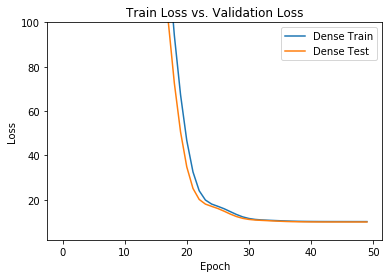

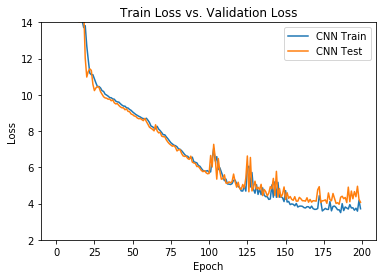

In [49]:
#Plot the Traditional Neural Network Training Curve
plt.plot(history_Dense.history['loss'])
plt.plot(history_Dense.history['val_loss'])
plt.title('Train Loss vs. Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Dense Train', 'Dense Test'], loc ='upper right')
plt.ylim(2,100)
plt.show()

#Plot the Convolutional Neural Network Training Curve
plt.plot(history_CNN.history['loss'])
plt.plot(history_CNN.history['val_loss'])
plt.title('Train Loss vs. Validation Loss')
plt.legend(['CNN Train', 'CNN Test'], loc ='upper right')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(2,14)
plt.show()

## Free-Form Visualization
In this section, you will need to provide some form of visualization that emphasizes an important quality about the project. It is much more free-form, but should reasonably support a significant result or characteristic about the problem that you want to discuss.


In [50]:
#Predict values for images using CNN
img_result = model_CNN.predict(X_train_CNN[0:2])

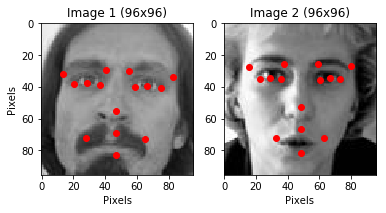

In [60]:
#Separate x,y coordinates to place on scatter plot
img_x,img_y = [[],[]],[[],[]]
for e in range(0,len(img_result)):
    for i in range(0, len(img_result[0])):
        if i%2==0:
            img_x[e].append(img_result[e][i])
        else:
            img_y[e].append(img_result[e][i])

#Import images
im1 = plt.imread('Data/imgs/1.jpg')
im2 = plt.imread('Data/imgs/2.jpg')

#Set as base for scatter plot and place coordinates for scatter plot
fig = plt.figure()
plot=fig.add_subplot(1,2,1)
plt.title('Image 1 (96x96)')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
implot = plt.imshow(im1)
plt.scatter(img_x[0],img_y[0], color ='r')
plot=fig.add_subplot(1,2,2)
plt.title('Image 2 (96x96)')
plt.xlabel('Pixels')
implot = plt.imshow(im2)
plt.scatter(img_x[1],img_y[1], color ='r')
    